In [1]:
import sys
sys.path.append("/home/jarlehti/projects/gradu")

In [2]:
import os
import glob
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import dill
import pandas as pd
from src.napsu_mq.napsu_mq import NapsuMQResult
import pickle
import numpy as np
from pprint import pprint
from tqdm.notebook import tqdm
from src.utils.string_utils import epsilon_str_to_float

In [3]:
CURRENT_FOLDER = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
LOG_FOLDER = os.path.join(CURRENT_FOLDER, "logs")
MODELS = os.path.join(CURRENT_FOLDER, "models")
BU_MODELS_FOLDER = os.path.join(os.path.dirname(CURRENT_FOLDER), "cluster_backup", "gradu_cluster_backup_05042023", "models")
BU_LOGS_FOLDER = os.path.join(os.path.dirname(CURRENT_FOLDER), "cluster_backup", "gradu_cluster_backup_140423", "logs")
BU_LOGS_FOLDER2 = os.path.join(os.path.dirname(CURRENT_FOLDER), "cluster_backup", "gradu_cluster_backup_16042023", "logs")
BU_FOLDER2 = os.path.join(os.path.dirname(CURRENT_FOLDER), "cluster_backup", "gradu_cluster_backup_16042023")

In [4]:
inference_data_files = glob.glob(os.path.join(BU_LOGS_FOLDER2, 'inf_data_linear_regression_dummy_5x*_*e_*_repeat.nc'))

In [5]:
pprint(sorted(inference_data_files))

['/home/local/jarlehti/projects/cluster_backup/gradu_cluster_backup_16042023/logs/inf_data_linear_regression_dummy_5x2_01e_0_repeat.nc',
 '/home/local/jarlehti/projects/cluster_backup/gradu_cluster_backup_16042023/logs/inf_data_linear_regression_dummy_5x2_01e_10_repeat.nc',
 '/home/local/jarlehti/projects/cluster_backup/gradu_cluster_backup_16042023/logs/inf_data_linear_regression_dummy_5x2_01e_11_repeat.nc',
 '/home/local/jarlehti/projects/cluster_backup/gradu_cluster_backup_16042023/logs/inf_data_linear_regression_dummy_5x2_01e_12_repeat.nc',
 '/home/local/jarlehti/projects/cluster_backup/gradu_cluster_backup_16042023/logs/inf_data_linear_regression_dummy_5x2_01e_13_repeat.nc',
 '/home/local/jarlehti/projects/cluster_backup/gradu_cluster_backup_16042023/logs/inf_data_linear_regression_dummy_5x2_01e_14_repeat.nc',
 '/home/local/jarlehti/projects/cluster_backup/gradu_cluster_backup_16042023/logs/inf_data_linear_regression_dummy_5x2_01e_15_repeat.nc',
 '/home/local/jarlehti/projects/clu

In [99]:
inf_data = az.from_netcdf(str(inference_data_files[0]))

In [102]:
inf_data

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [235]:
df = pd.DataFrame(columns=['dataset', 'epsilon', 'chain', 'repeat_index', 'n_steps_mean', 'n_steps_std', 'acceptance_rate_mean', 'acceptance_rate_std', 'tree_depth_mean', 'tree_depth_std', 'diverging_mean', 'diverging_std'])

for path in inference_data_files:
    path_splits = path.split("_")
    epsilon = epsilon_str_to_float(path_splits[-3].replace("e", ""))
    dataset = f"{path_splits[-5]}_{path_splits[-4]}"
    repeat_index = path_splits[-2]
    
    inf_data = az.from_netcdf(path)
    
    step_mean = np.mean(inf_data.sample_stats.n_steps.to_numpy(), axis=1)
    step_std = np.std(inf_data.sample_stats.n_steps.to_numpy(), axis=1)
    
    acceptance_rate_mean = np.mean(inf_data.sample_stats.acceptance_rate.to_numpy(), axis=1)
    acceptance_rate_std = np.std(inf_data.sample_stats.acceptance_rate.to_numpy(), axis=1)
    
    tree_depth_mean = np.mean(inf_data.sample_stats.tree_depth.to_numpy(), axis=1)
    tree_depth_std = np.std(inf_data.sample_stats.tree_depth.to_numpy(), axis=1)
    
    diverging_mean = np.mean(inf_data.sample_stats.diverging.to_numpy(), axis=1)
    diverging_std = np.std(inf_data.sample_stats.diverging.to_numpy(), axis=1)

    for i in range(len(step_mean)):
        n_step_mean = step_mean[i]
        n_step_std = step_std[i]
        accep_rate_mean = acceptance_rate_mean[i]
        accep_rate_std = acceptance_rate_std[i]
        td_mean = tree_depth_mean[i]
        td_std = tree_depth_std[i]
        
        dv_mean = diverging_mean[i]
        dv_std = diverging_std[i]
        
        df.loc[len(df)] = [dataset, epsilon, i, repeat_index, n_step_mean, n_step_std, accep_rate_mean, accep_rate_std, td_mean, td_std, dv_mean, dv_std]

In [236]:
df = df.sort_values(by=['dataset', 'epsilon', 'chain', 'repeat_index'])

In [237]:
df

,dataset,epsilon,chain,repeat_index,n_steps_mean,n_steps_std,acceptance_rate_mean,acceptance_rate_std,tree_depth_mean,tree_depth_std,diverging_mean,diverging_std
592,dummy_5x2,0.1,0,0,5.916,1.777904,0.849899,0.143387,2.7290,0.444476,0.0,0.0
484,dummy_5x2,0.1,0,1,6.786,0.900113,0.914224,0.086281,2.9465,0.225028,0.0,0.0
44,dummy_5x2,0.1,0,10,6.150,1.636307,0.864310,0.132598,2.7875,0.409077,0.0,0.0
392,dummy_5x2,0.1,0,11,6.788,0.896134,0.911752,0.089733,2.9470,0.224033,0.0,0.0
224,dummy_5x2,0.1,0,12,6.664,1.109551,0.897902,0.105499,2.9160,0.277388,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1835,dummy_5x7,8.0,3,5,14.252,2.768483,0.840847,0.133318,3.9020,0.315271,0.0,0.0
1263,dummy_5x7,8.0,3,6,14.988,0.309606,0.869146,0.116352,3.9985,0.038701,0.0,0.0
599,dummy_5x7,8.0,3,7,14.376,2.145373,0.845597,0.133881,3.9220,0.268172,0.0,0.0
495,dummy_5x7,8.0,3,8,7.176,1.252607,0.802253,0.165853,3.0220,0.156576,0.0,0.0


<Figure size 1600x1600 with 0 Axes>

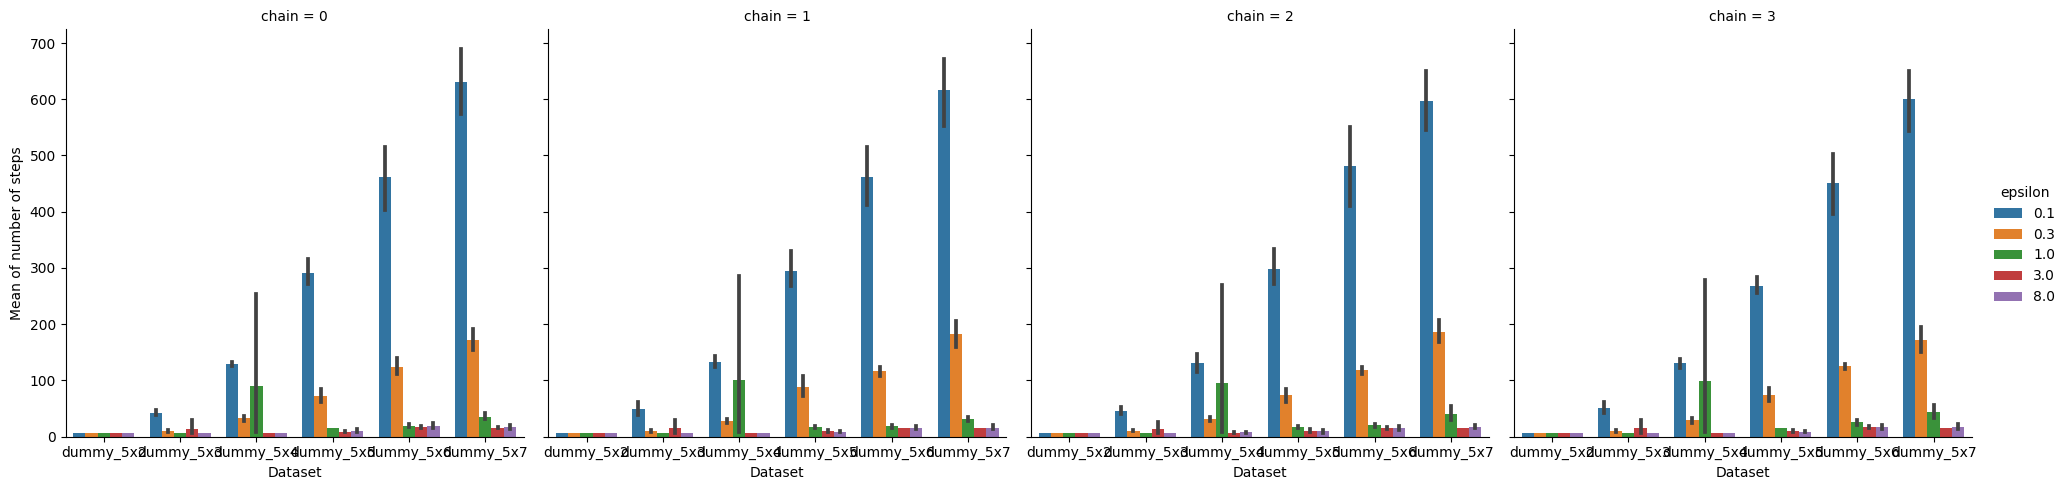

<Figure size 1600x1600 with 0 Axes>

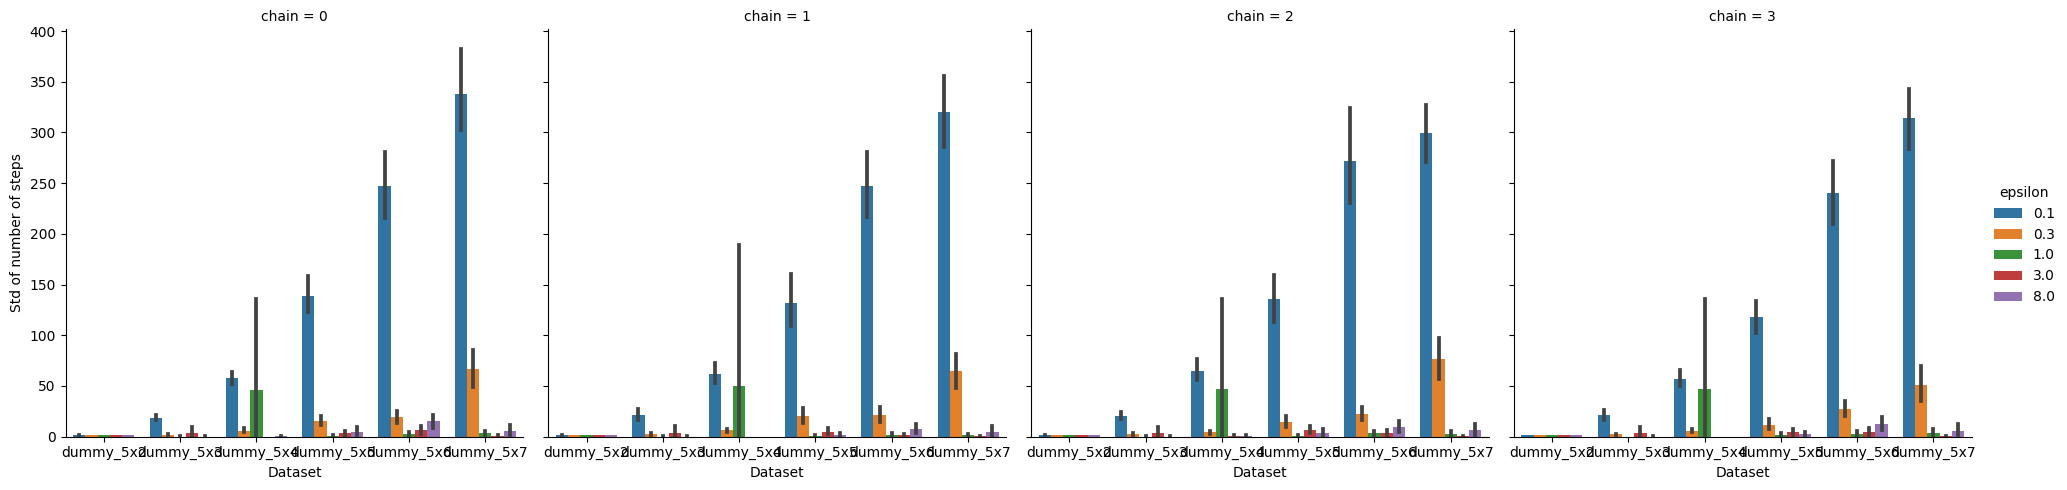

In [238]:
plt.figure(figsize=(16, 16))
f = sns.catplot(data=df, kind="bar", x="dataset", y="n_steps_mean", hue="epsilon", col="chain")
plt.figure(figsize=(16, 16))
g = sns.catplot(data=df, kind="bar", x="dataset", y="n_steps_std", hue="epsilon", col="chain")

f.set_xlabels("Dataset")
f.set_ylabels("Mean of number of steps")

g.set_xlabels("Dataset")
g.set_ylabels("Std of number of steps")

f.savefig("runtime_estimation_stepsize_means.png")
g.savefig("runtime_estimation_stepsize_stds.png")

<Figure size 1600x1600 with 0 Axes>

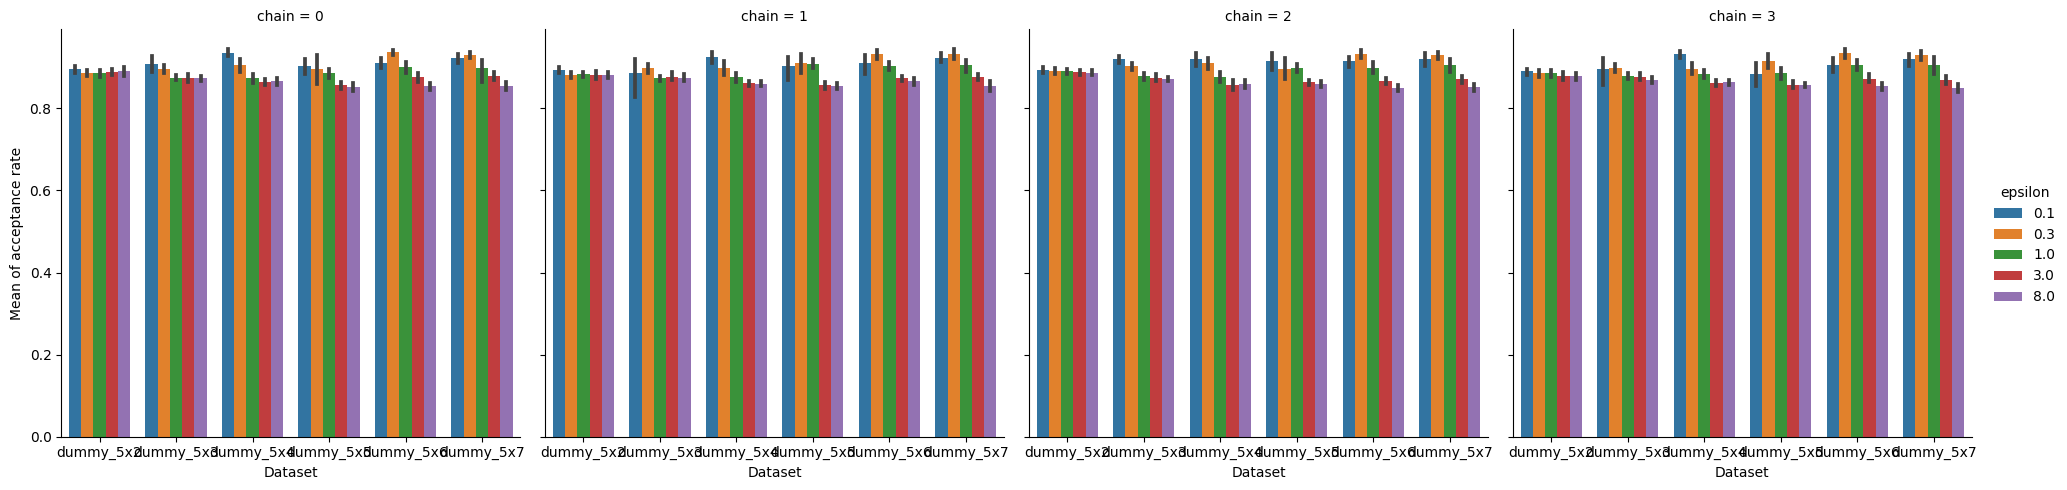

<Figure size 1600x1600 with 0 Axes>

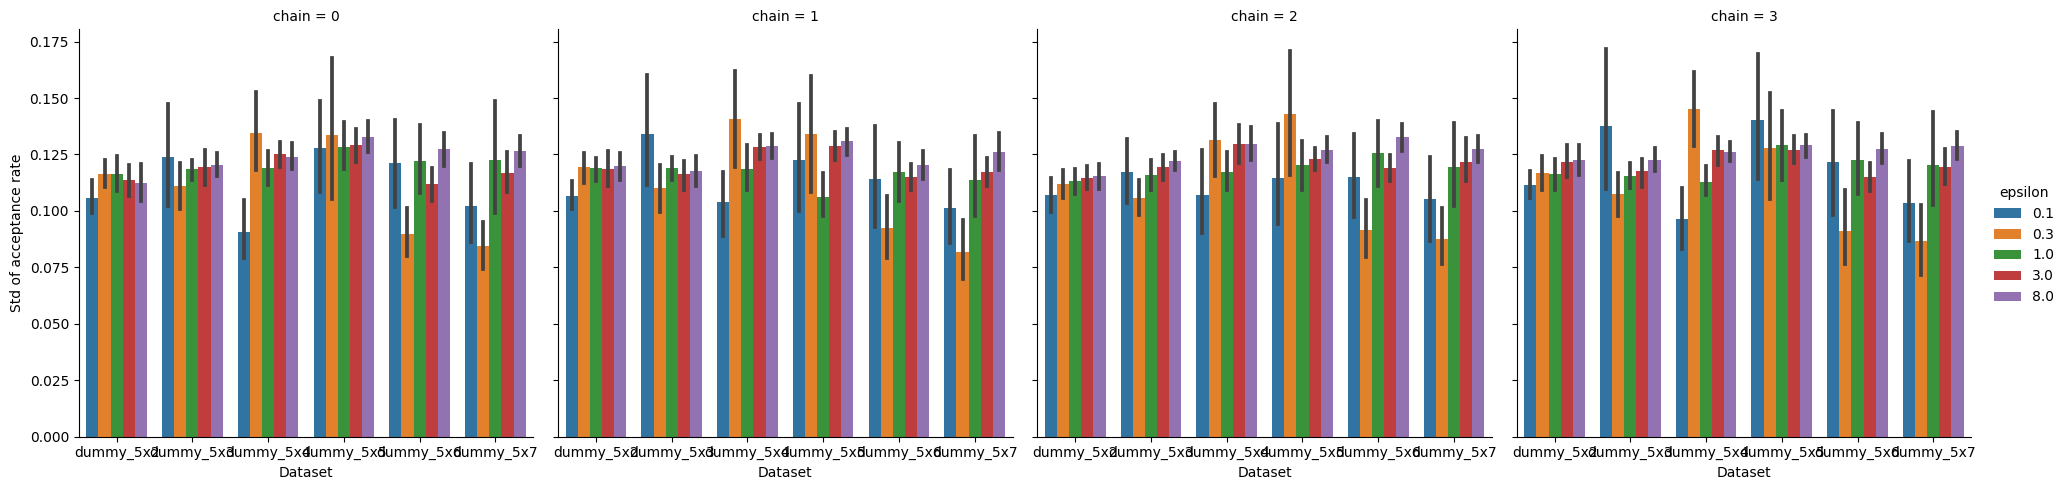

In [239]:
plt.figure(figsize=(16, 16))
f = sns.catplot(data=df, kind="bar", x="dataset", y="acceptance_rate_mean", hue="epsilon", col="chain")
plt.figure(figsize=(16, 16))
g = sns.catplot(data=df, kind="bar", x="dataset", y="acceptance_rate_std", hue="epsilon", col="chain")

f.set_xlabels("Dataset")
f.set_ylabels("Mean of acceptance rate")

g.set_xlabels("Dataset")
g.set_ylabels("Std of acceptance rate")

f.savefig("runtime_estimation_accept_rate_means.png")
g.savefig("runtime_estimation_accept_rate_stds.png")

<Figure size 1600x1600 with 0 Axes>

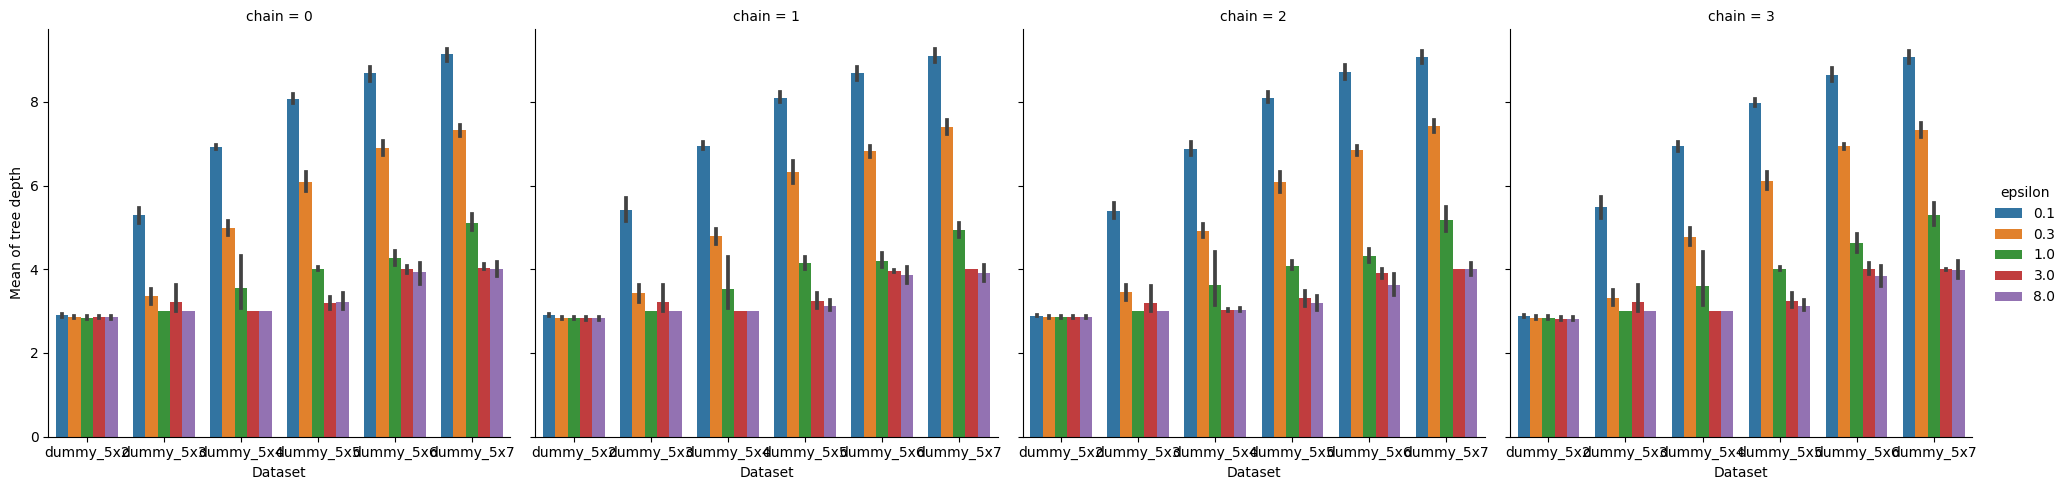

<Figure size 1600x1600 with 0 Axes>

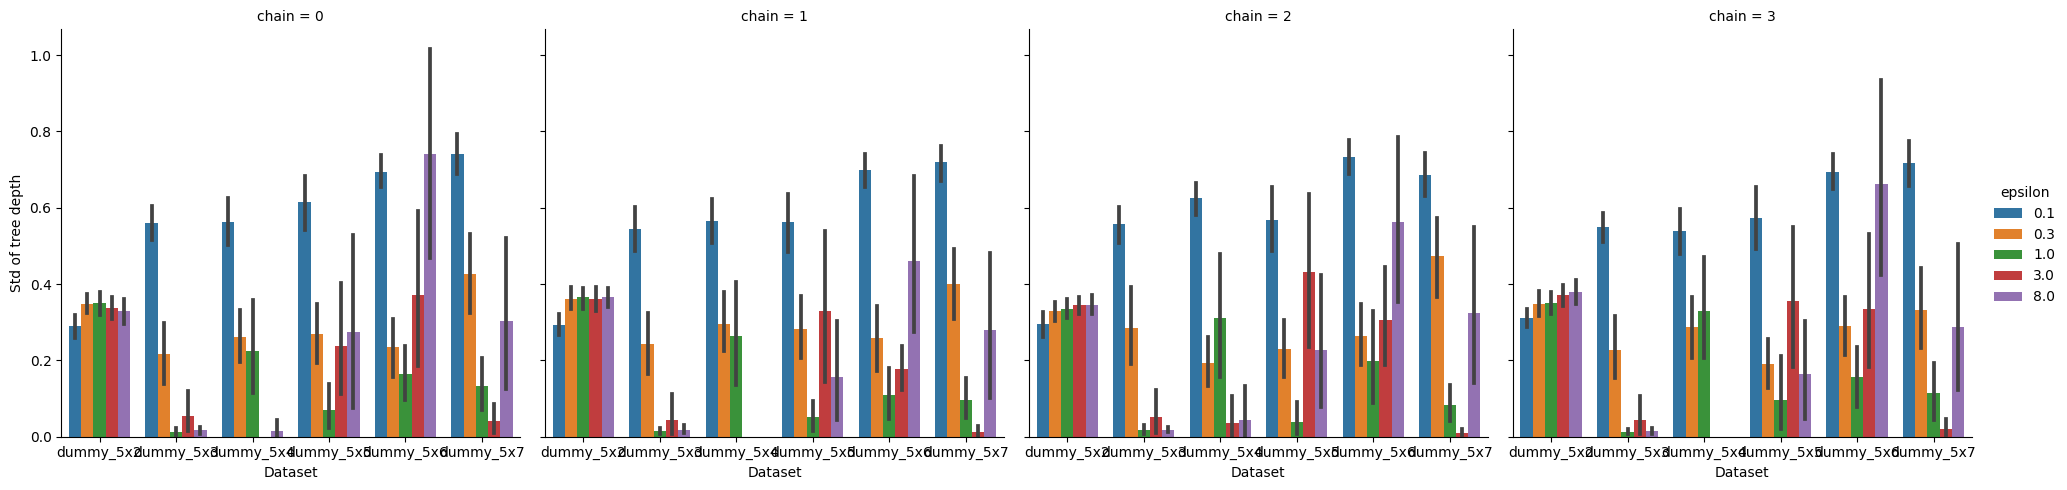

In [240]:
plt.figure(figsize=(16, 16))
f = sns.catplot(data=df, kind="bar", x="dataset", y="tree_depth_mean", hue="epsilon", col="chain")
plt.figure(figsize=(16, 16))
g = sns.catplot(data=df, kind="bar", x="dataset", y="tree_depth_std", hue="epsilon", col="chain")

f.set_xlabels("Dataset")
f.set_ylabels("Mean of tree depth")

g.set_xlabels("Dataset")
g.set_ylabels("Std of tree depth")

f.savefig("runtime_estimation_tree_depth_means.png")
g.savefig("runtime_estimation_tree_depth_stds.png")

<Figure size 1600x1600 with 0 Axes>

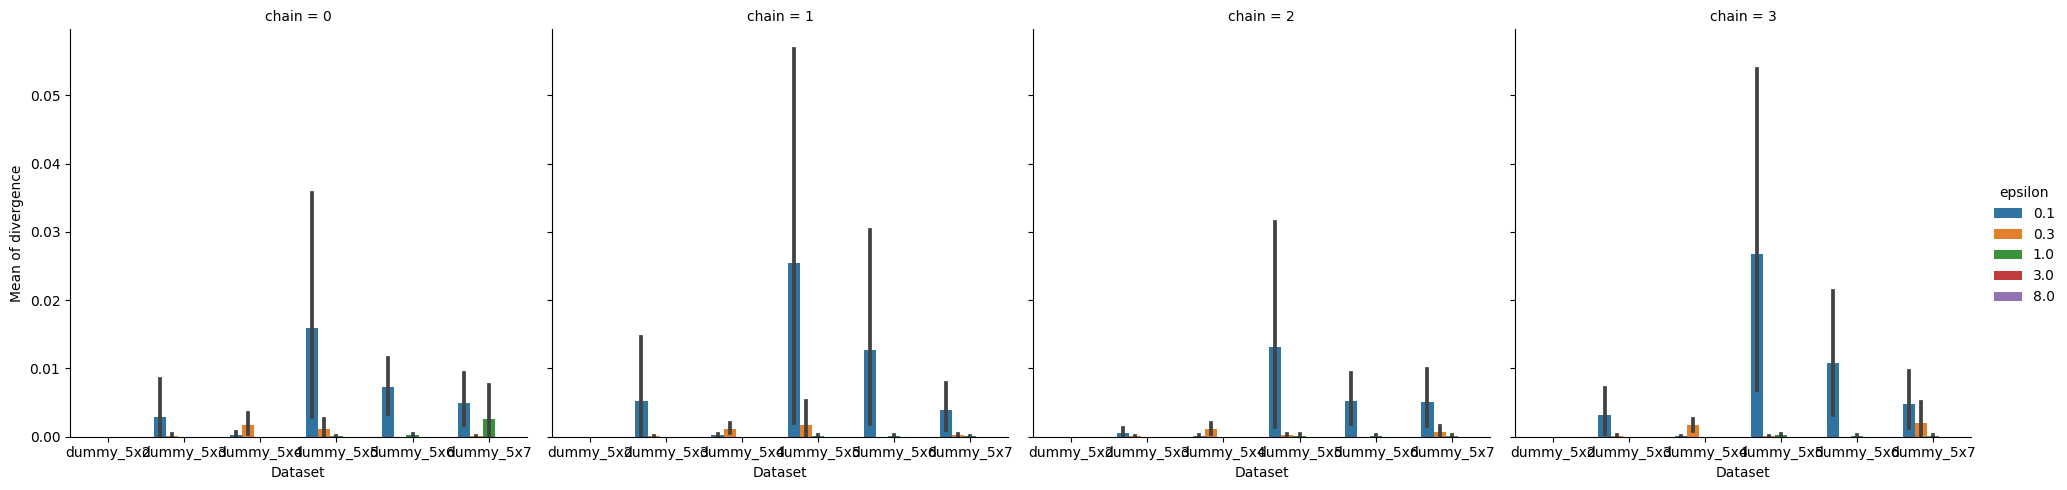

<Figure size 1600x1600 with 0 Axes>

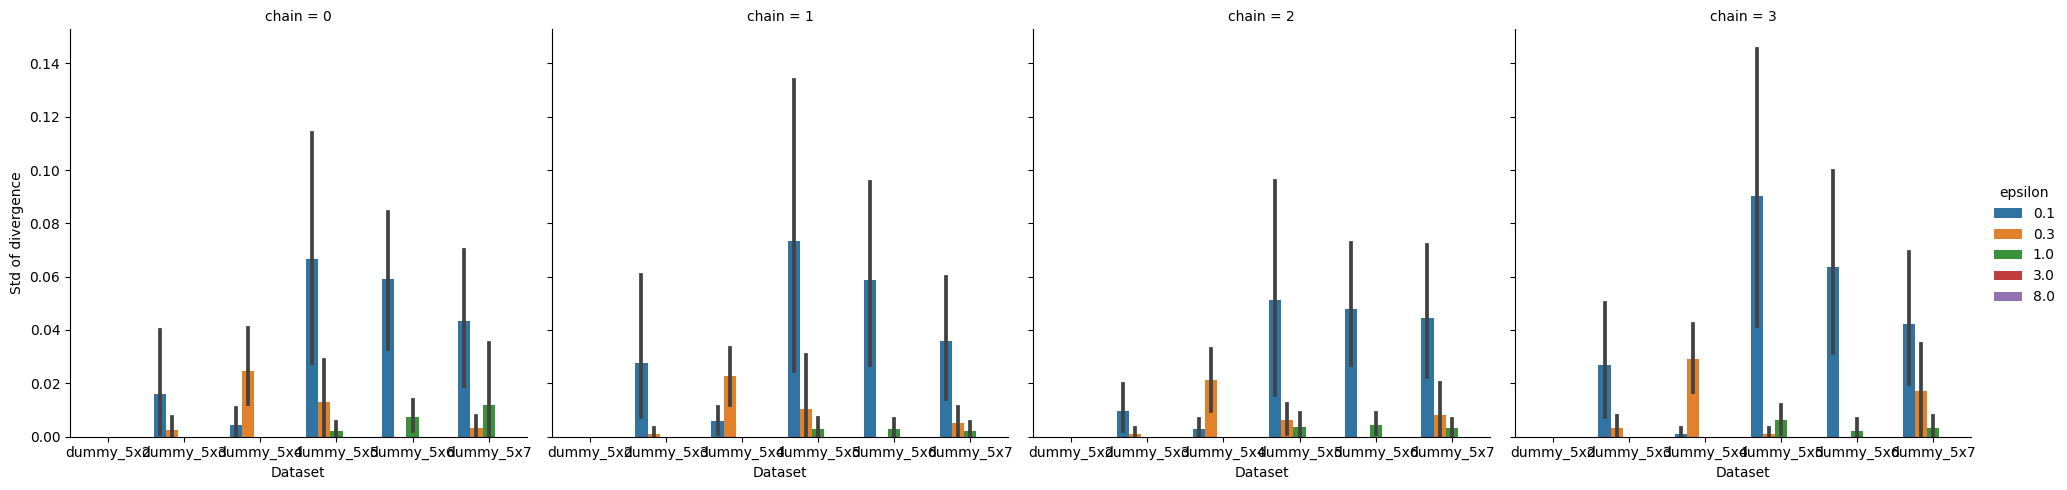

In [242]:
plt.figure(figsize=(16, 16))
f = sns.catplot(data=df, kind="bar", x="dataset", y="diverging_mean", hue="epsilon", col="chain")
plt.figure(figsize=(16, 16))
g = sns.catplot(data=df, kind="bar", x="dataset", y="diverging_std", hue="epsilon", col="chain")

f.set_xlabels("Dataset")
f.set_ylabels("Mean of divergence")

g.set_xlabels("Dataset")
g.set_ylabels("Std of divergence")

In [16]:
master_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
norm_lambdas[0],0.510,1.184,-1.270,2.710,0.019,0.014,4672.0,4928.0,1.00
norm_lambdas[1],0.006,1.144,-2.114,2.120,0.014,0.016,7429.0,4196.0,1.00
norm_lambdas[2],0.093,1.084,-1.882,2.183,0.012,0.013,8156.0,5190.0,1.00
norm_lambdas[3],-0.367,1.707,-2.811,2.005,0.053,0.048,3769.0,1614.0,1.00
norm_lambdas[4],0.716,1.475,-1.260,3.529,0.026,0.019,3540.0,4993.0,1.00
...,...,...,...,...,...,...,...,...,...
norm_lambdas[120],-5.962,3.712,-12.528,0.788,0.084,0.059,1999.0,3855.0,1.00
norm_lambdas[121],-18.472,15.626,-47.727,7.085,0.366,0.259,1712.0,3713.0,1.01
norm_lambdas[122],-19.236,11.965,-40.993,2.092,0.275,0.195,1896.0,3992.0,1.01
norm_lambdas[123],-29.098,18.939,-64.404,3.277,0.453,0.321,1723.0,3831.0,1.00


In [17]:
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
norm_lambdas[0],-0.007,1.007,-1.827,2.009,0.009,0.012,12441.0,6036.0,1.0
norm_lambdas[1],0.002,1.000,-1.839,1.869,0.010,0.012,11027.0,6201.0,1.0
norm_lambdas[2],0.002,0.998,-1.888,1.868,0.009,0.011,12467.0,6187.0,1.0
norm_lambdas[3],0.004,0.997,-1.894,1.834,0.009,0.012,13257.0,6324.0,1.0
norm_lambdas[4],0.002,0.995,-1.894,1.841,0.009,0.013,12844.0,5333.0,1.0
norm_lambdas[5],-0.015,0.998,-1.947,1.802,0.009,0.012,13177.0,6293.0,1.0
norm_lambdas[6],0.007,0.979,-1.855,1.811,0.009,0.012,11873.0,6275.0,1.0


In [12]:
for data in inference_data_files:
    inf_data = az.from_netcdf(data)
    print(az.summary(inf_data))

                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
norm_lambdas[0]  0.017  0.988  -1.973    1.757      0.009    0.011   12943.0   
norm_lambdas[1]  0.007  0.985  -1.798    1.870      0.008    0.011   13845.0   
norm_lambdas[2]  0.016  1.003  -1.872    1.849      0.009    0.012   11179.0   
norm_lambdas[3]  0.011  0.992  -1.847    1.838      0.009    0.011   12120.0   
norm_lambdas[4] -0.013  0.994  -1.837    1.865      0.009    0.011   11989.0   
norm_lambdas[5] -0.004  0.985  -1.745    1.932      0.009    0.011   11462.0   
norm_lambdas[6]  0.002  1.004  -1.829    1.892      0.009    0.011   13323.0   

                 ess_tail  r_hat  
norm_lambdas[0]    6192.0    1.0  
norm_lambdas[1]    6350.0    1.0  
norm_lambdas[2]    5953.0    1.0  
norm_lambdas[3]    6460.0    1.0  
norm_lambdas[4]    6403.0    1.0  
norm_lambdas[5]    6270.0    1.0  
norm_lambdas[6]    6410.0    1.0  
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \

                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
norm_lambdas[0]  0.012  0.987  -1.790    1.918      0.008    0.011   13690.0   
norm_lambdas[1]  0.002  0.994  -1.878    1.833      0.009    0.012   13129.0   
norm_lambdas[2]  0.017  1.011  -1.855    1.949      0.009    0.012   12007.0   
norm_lambdas[3]  0.009  1.007  -1.854    1.886      0.009    0.012   11559.0   
norm_lambdas[4] -0.010  0.998  -1.854    1.874      0.009    0.011   13417.0   
norm_lambdas[5] -0.002  0.984  -1.791    1.903      0.009    0.012   12846.0   
norm_lambdas[6] -0.007  1.000  -1.803    1.905      0.009    0.011   13193.0   

                 ess_tail  r_hat  
norm_lambdas[0]    6344.0    1.0  
norm_lambdas[1]    6519.0    1.0  
norm_lambdas[2]    5883.0    1.0  
norm_lambdas[3]    5824.0    1.0  
norm_lambdas[4]    6194.0    1.0  
norm_lambdas[5]    6101.0    1.0  
norm_lambdas[6]    6318.0    1.0  
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \

                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
norm_lambdas[0]  0.006  0.991  -1.846    1.858      0.009    0.012   13315.0   
norm_lambdas[1]  0.000  0.993  -1.884    1.833      0.009    0.011   12450.0   
norm_lambdas[2]  0.010  1.014  -1.939    1.841      0.009    0.012   11889.0   
norm_lambdas[3]  0.008  0.991  -1.848    1.869      0.009    0.011   11754.0   
norm_lambdas[4] -0.005  1.001  -1.811    1.875      0.009    0.012   11920.0   
norm_lambdas[5]  0.006  0.974  -1.845    1.810      0.009    0.011   12291.0   
norm_lambdas[6]  0.010  1.009  -1.867    1.879      0.009    0.011   13304.0   

                 ess_tail  r_hat  
norm_lambdas[0]    6125.0    1.0  
norm_lambdas[1]    6413.0    1.0  
norm_lambdas[2]    5696.0    1.0  
norm_lambdas[3]    6276.0    1.0  
norm_lambdas[4]    5922.0    1.0  
norm_lambdas[5]    6327.0    1.0  
norm_lambdas[6]    6069.0    1.0  
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \

                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
norm_lambdas[0] -0.009  0.994  -1.863    1.820      0.009    0.012   12877.0   
norm_lambdas[1]  0.003  0.994  -1.846    1.873      0.009    0.011   13045.0   
norm_lambdas[2]  0.020  1.016  -1.923    1.837      0.009    0.012   12646.0   
norm_lambdas[3]  0.015  0.992  -1.811    1.873      0.009    0.012   11347.0   
norm_lambdas[4] -0.012  1.000  -1.847    1.898      0.009    0.011   11846.0   
norm_lambdas[5] -0.001  0.984  -1.830    1.856      0.009    0.011   12394.0   
norm_lambdas[6]  0.004  1.014  -1.892    1.879      0.009    0.012   13900.0   

                 ess_tail  r_hat  
norm_lambdas[0]    6022.0    1.0  
norm_lambdas[1]    6264.0    1.0  
norm_lambdas[2]    5897.0    1.0  
norm_lambdas[3]    5666.0    1.0  
norm_lambdas[4]    6024.0    1.0  
norm_lambdas[5]    6445.0    1.0  
norm_lambdas[6]    6449.0    1.0  
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \

                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
norm_lambdas[0]  0.006  0.993  -1.842    1.852       0.01    0.011    9649.0   
norm_lambdas[1] -0.003  0.996  -1.858    1.866       0.01    0.011   10767.0   
norm_lambdas[2] -0.004  1.000  -1.882    1.891       0.01    0.011   10588.0   
norm_lambdas[3] -0.009  0.984  -1.914    1.781       0.01    0.011    9476.0   
norm_lambdas[4]  0.001  1.002  -2.020    1.743       0.01    0.011   10144.0   

                 ess_tail  r_hat  
norm_lambdas[0]    5878.0    1.0  
norm_lambdas[1]    6430.0    1.0  
norm_lambdas[2]    5947.0    1.0  
norm_lambdas[3]    5914.0    1.0  
norm_lambdas[4]    5899.0    1.0  
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
norm_lambdas[0]  0.004  1.007  -1.882    1.871       0.01    0.011    9971.0   
norm_lambdas[1] -0.005  0.999  -1.836    1.892       0.01    0.012   10081.0   
norm_lambdas[2]  0.012  1.009  -1.942    1.868       0.01    0.011   

                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
norm_lambdas[0]  0.012  1.000  -1.887    1.893      0.008    0.011   14137.0   
norm_lambdas[1] -0.002  0.985  -1.751    1.935      0.009    0.012   13177.0   
norm_lambdas[2]  0.014  1.000  -1.912    1.816      0.009    0.012   12005.0   
norm_lambdas[3]  0.009  0.988  -1.834    1.845      0.009    0.011   12776.0   
norm_lambdas[4] -0.007  1.004  -1.864    1.878      0.009    0.012   13107.0   
norm_lambdas[5]  0.011  0.987  -1.758    1.932      0.009    0.012   12225.0   
norm_lambdas[6] -0.002  1.005  -1.887    1.854      0.008    0.012   14363.0   

                 ess_tail  r_hat  
norm_lambdas[0]    6381.0    1.0  
norm_lambdas[1]    5968.0    1.0  
norm_lambdas[2]    6364.0    1.0  
norm_lambdas[3]    6422.0    1.0  
norm_lambdas[4]    6167.0    1.0  
norm_lambdas[5]    5954.0    1.0  
norm_lambdas[6]    5448.0    1.0  
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \

Sampling normal distribution
Plotting posterior from /home/local/jarlehti/projects/cluster_backup/gradu_cluster_backup_16042023/logs/inf_data_linear_regression_dummy_5x3_01e_0_repeat.nc
Plotting posterior from /home/local/jarlehti/projects/cluster_backup/gradu_cluster_backup_16042023/logs/inf_data_linear_regression_dummy_5x3_01e_1_repeat.nc
Plotting posterior from /home/local/jarlehti/projects/cluster_backup/gradu_cluster_backup_16042023/logs/inf_data_linear_regression_dummy_5x3_01e_2_repeat.nc
Plotting posterior from /home/local/jarlehti/projects/cluster_backup/gradu_cluster_backup_16042023/logs/inf_data_linear_regression_dummy_5x3_01e_3_repeat.nc
Plotting posterior from /home/local/jarlehti/projects/cluster_backup/gradu_cluster_backup_16042023/logs/inf_data_linear_regression_dummy_5x3_01e_4_repeat.nc
Plotting posterior from /home/local/jarlehti/projects/cluster_backup/gradu_cluster_backup_16042023/logs/inf_data_linear_regression_dummy_5x3_01e_5_repeat.nc
Plotting posterior from /home

Plotting posterior from /home/local/jarlehti/projects/cluster_backup/gradu_cluster_backup_16042023/logs/inf_data_linear_regression_dummy_5x3_10e_12_repeat.nc
Plotting posterior from /home/local/jarlehti/projects/cluster_backup/gradu_cluster_backup_16042023/logs/inf_data_linear_regression_dummy_5x3_10e_13_repeat.nc
Plotting posterior from /home/local/jarlehti/projects/cluster_backup/gradu_cluster_backup_16042023/logs/inf_data_linear_regression_dummy_5x3_10e_14_repeat.nc
Plotting posterior from /home/local/jarlehti/projects/cluster_backup/gradu_cluster_backup_16042023/logs/inf_data_linear_regression_dummy_5x3_10e_15_repeat.nc
Plotting posterior from /home/local/jarlehti/projects/cluster_backup/gradu_cluster_backup_16042023/logs/inf_data_linear_regression_dummy_5x3_10e_16_repeat.nc
Plotting posterior from /home/local/jarlehti/projects/cluster_backup/gradu_cluster_backup_16042023/logs/inf_data_linear_regression_dummy_5x3_10e_17_repeat.nc
Plotting posterior from /home/local/jarlehti/project

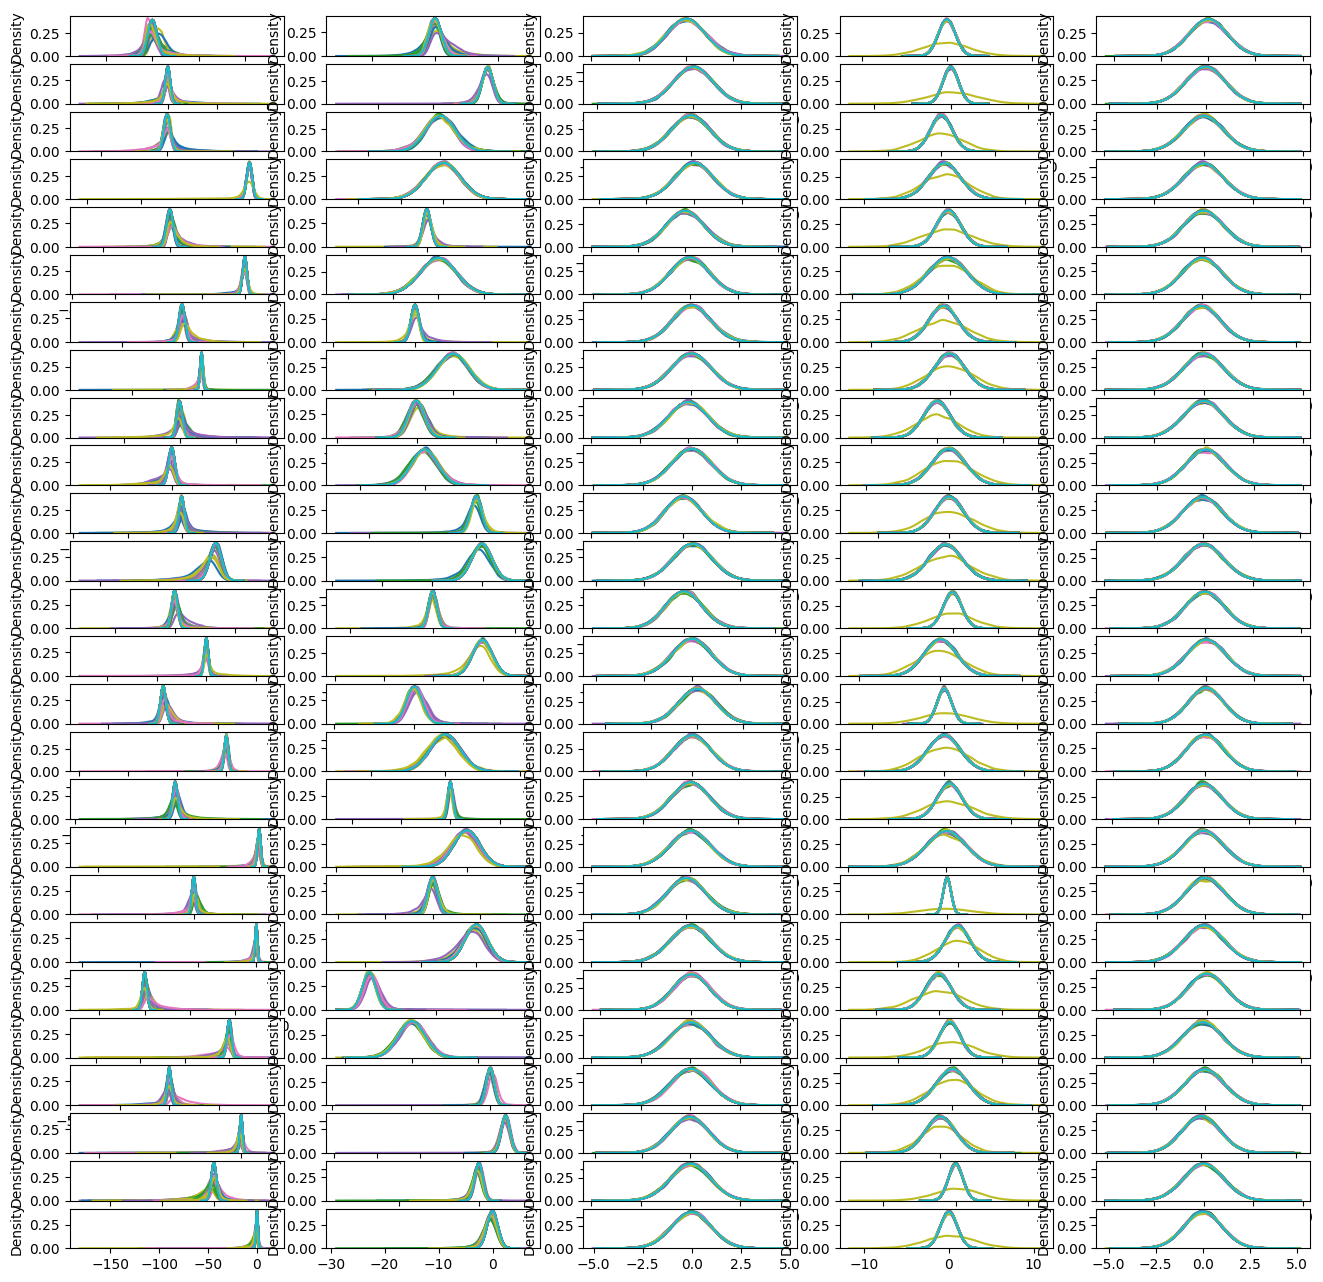

In [9]:
print(f"Sampling normal distribution")
x = np.random.normal(size=1000000)

epsilons = ["01", "03", "10", "30", "80"]
n_repeats = 20
dims = 26
data_type = "5x3" 

fig, ax = plt.subplots(dims, len(epsilons), figsize=(, 16))

for eps_index, epsilon in enumerate(epsilons):
    for repeat_index in range(n_repeats):
        file = os.path.join(BU_LOGS_FOLDER2, f"inf_data_linear_regression_dummy_{data_type}_{epsilon}e_{repeat_index}_repeat.nc")
    
        print(f"Plotting posterior from {file}")

        inf_data = az.from_netcdf(file)

        posterior_values = inf_data.posterior.stack(draws=("chain", "draw"))
        posterior_values = posterior_values.norm_lambdas.values.transpose()

        samples, dims = posterior_values.shape

        for i in range(dims):
            sns.kdeplot(posterior_values[:, i], ax=ax[i, eps_index], label="MCMC")
            sns.kdeplot(x, ax=ax[i, eps_index], label="N(0,1)")

plt.show()

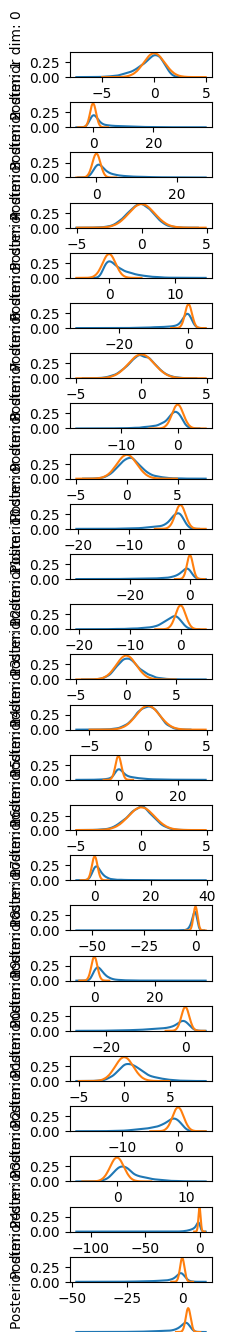

<Figure size 6400x6400 with 0 Axes>

In [354]:
[ax.get_xaxis().set_visible(True) for ax in fig.axes]
[ax.get_yaxis().set_visible(True) for ax in fig.axes]

epsilons = [0.1, 0.3, 1.0, 3.0, 8.0]

for i, row in enumerate(ax):
    for j, cell in enumerate(row):
        if i == len(ax) - 1:
            cell.set_xlabel(f"Epsilon: {epsilons[j]}")
        if j == 0:
            cell.set_ylabel(f"Posterior dim: {i}")
        else:
            cell.axes.get_xaxis().set_visible(True)
            cell.set_xlabel("")
            cell.set_ylabel("")

plt.figure(figsize=(64, 64))
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=1, hspace=1)
fig

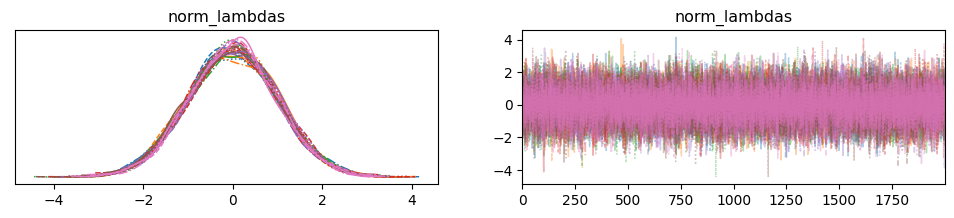

In [27]:
az.plot_trace(inf_data)
plt.show()

In [8]:
inference_data_files[8]

'/home/local/jarlehti/projects/gradu/logs/inf_data_binary4d_AC_30e_NUTS.nc'

In [22]:
model_path = os.path.join(BU_MODELS_FOLDER, "napsu_original_model_binary4d_80e_A+D-B+D-C+D.dill")
model_binary = open(model_path, "rb")
model = NapsuMQResult.load(model_binary)

In [23]:
model.meta

{'experiment_id': 'CVAZLCY9',
 'dataset_name': 'binary4d',
 'query_str': 'A+D-B+D-C+D',
 'query_list': [['A', 'D'], ['B', 'D'], ['C', 'D']],
 'epsilon': 8.0,
 'delta': 1e-10,
 'MCMC_algo': 'NUTS',
 'laplace_approximation': True,
 'missing_query': None,
 'discretization': None,
 'n_canonical_queries': 7,
 'junction_tree_width': 2,
 'suff_stat_dim': (7,),
 'laplace_approximation_algorithm': 'torch_LBFGS'}

In [20]:
posterior_values_orig = np.array(model.posterior_values)

In [25]:
# From another notebook train_NAPSU_model
laplace_approximation_means = [-0.0139, -0.0191,  0.2812, -0.6882,  0.0754,  0.3976, -1.5303]

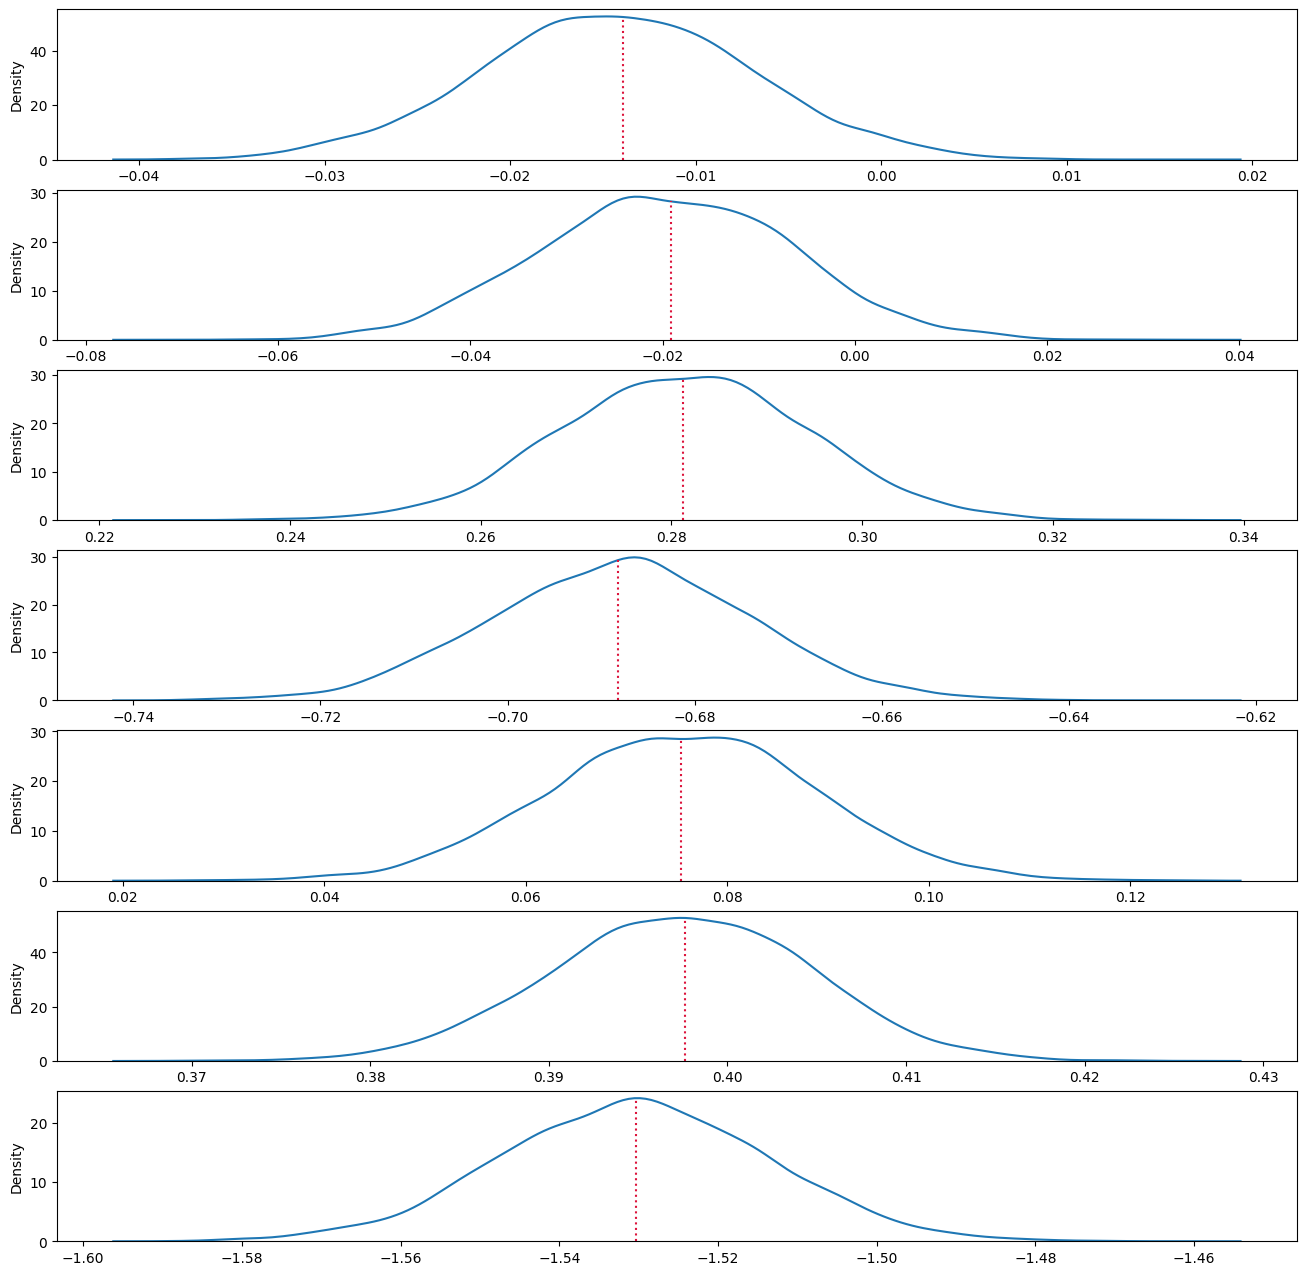

In [26]:
fig, ax = plt.subplots(7, figsize=(16, 16))

for i in range(7):
    sns.kdeplot(posterior_values_orig[:, i], ax=ax[i], label="MCMC")
    
    kdeline = ax[i].lines[0]
    mean = laplace_approximation_means[i]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    height = np.interp(mean, xs, ys)
    ax[i].vlines(mean, 0, height, color='crimson', ls=':')

In [112]:
file = os.path.join(BU_LOGS_FOLDER2, "napsu_linear_regression_test_storage_OM8XMEPX.pickle")
data = pickle.load(open(file, "rb"))

In [138]:
data

{'norm_lambdas': OrderedDict([('mean', -0.6782215070514265),
              ('std', 3.8537874292079093),
              ('median', -0.04453639184863388),
              ('5.0%', -3.644868959409248),
              ('95.0%', 2.9079520736862685),
              ('n_eff', 603702.3638083569),
              ('r_hat', 1.0051656154428172)]),
 'accept_prob': DeviceArray([[0.80624417, 0.98787608, 0.81314486, ..., 0.94684569,
               0.99738433, 0.91405471],
              [0.9340892 , 0.97979296, 0.97823334, ..., 0.98118174,
               0.99687139, 0.89704412],
              [0.87385451, 0.98842133, 0.96542926, ..., 0.87367424,
               0.976637  , 0.98525745],
              [0.98192551, 0.99905794, 0.99116734, ..., 0.26779329,
               0.94530199, 0.88520948]], dtype=float64),
 'adapt_state': HMCAdaptState(step_size=DeviceArray([[0.03759128, 0.03759128, 0.03759128, ..., 0.03759128,
               0.03759128, 0.03759128],
              [0.03798009, 0.03798009, 0.03798009, ..., 0

In [132]:
step_sizes = data['adapt_state'].step_size
df = pd.DataFrame(data=step_sizes.T, columns=['chain1', 'chain2', 'chain3', 'chain4'])
df['index'] = np.array(list(range(0, 2000)))

In [134]:
df = pd.melt(df, id_vars=['index'], value_vars=['chain1', 'chain2', 'chain3', 'chain4'])

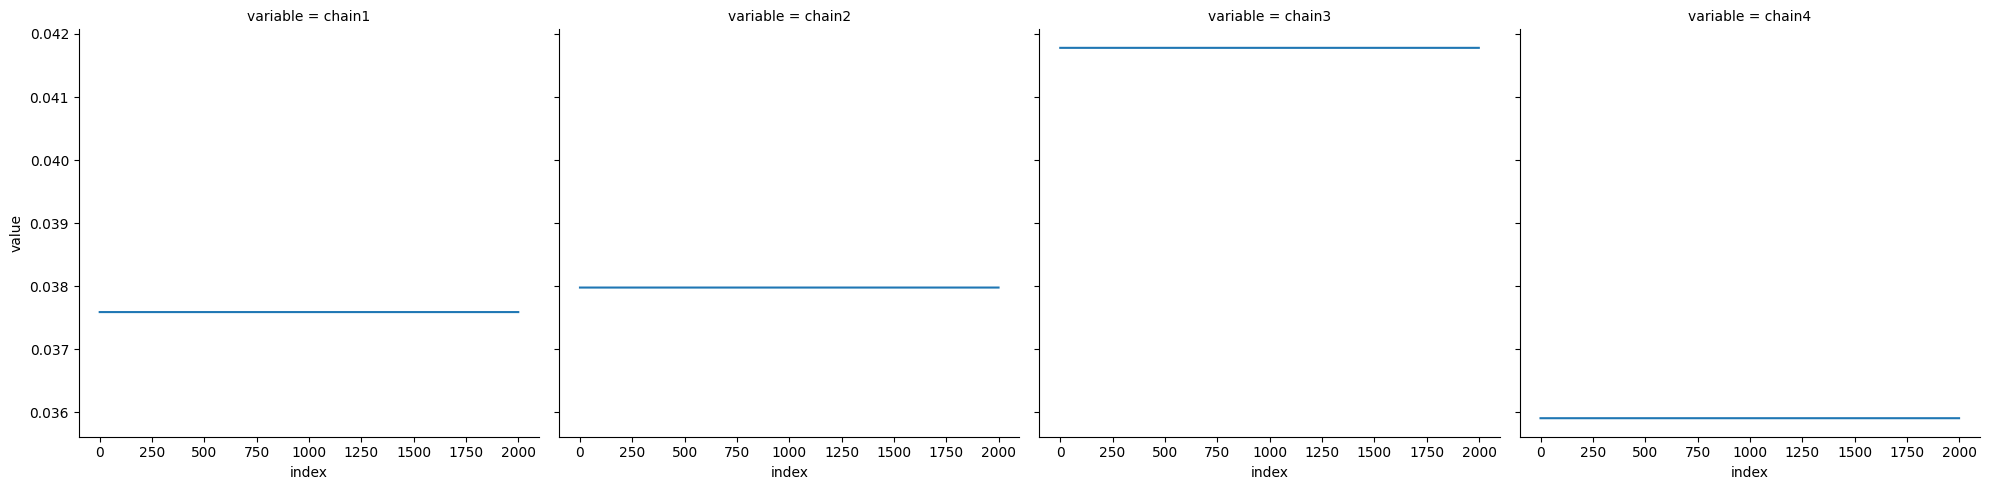

In [136]:
sns.relplot(
    data=df, kind="line", x="index",
    y="value", col="variable"
)

In [146]:
linear_regression_results = pd.read_csv(os.path.join(BU_FOLDER2, "napsu_linear_regression_test_timer.csv"))
linear_regression_results = linear_regression_results[linear_regression_results['start'] != 'start']

In [209]:
inference_data_files = glob.glob(os.path.join(BU_LOGS_FOLDER2, 'napsu_linear_regression_test_storage_*.pickle'))

step_df = pd.DataFrame(columns=['dataset', 'epsilon', 'chain', 'step_mean', 'step_std'])

for path in tqdm(inference_data_files):
    experiment_id = path[-15:-7] 
    
    file = os.path.join(BU_LOGS_FOLDER2, f"napsu_linear_regression_test_storage_{experiment_id}.pickle")
    try:
        data = pickle.load(open(file, "rb"))
    except:
        print(f"Could not find file {file}")
        
    row = linear_regression_results[(linear_regression_results['experiment_id'] == experiment_id) & (linear_regression_results['task'] == 'MCMC')]
    
    dataset = row['dataset_name'].item()
    epsilon = row['epsilon'].item()    
    
    step_means = np.mean(np.array(data['adapt_state'].step_size), axis=1)
        
    step_stds = np.std(np.array(data['adapt_state'].step_size), axis=1)
    
    for i in range(len(step_means)):
        step_mean = float(step_means[i])
        step_std = float(step_stds[i])
        step_df.loc[len(step_df)] = [dataset, epsilon, i, step_mean, step_std]

  0%|          | 0/598 [00:00<?, ?it/s]

In [210]:
step_df.dtypes

dataset       object
epsilon       object
chain          int64
step_mean    float64
step_std     float64
dtype: object

In [218]:
step_df = step_df.sort_values(by=['dataset', "epsilon", "chain"])

<Figure size 3000x1600 with 0 Axes>

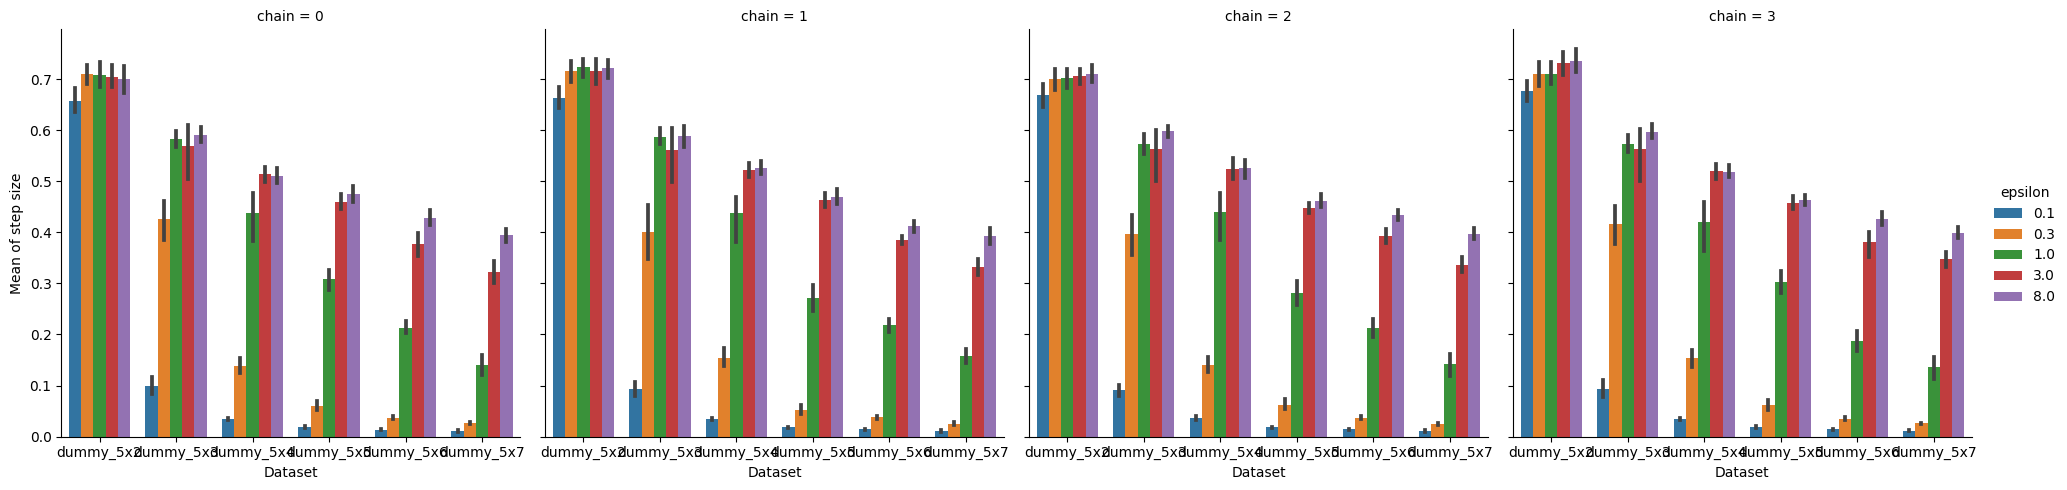

<Figure size 3000x1600 with 0 Axes>

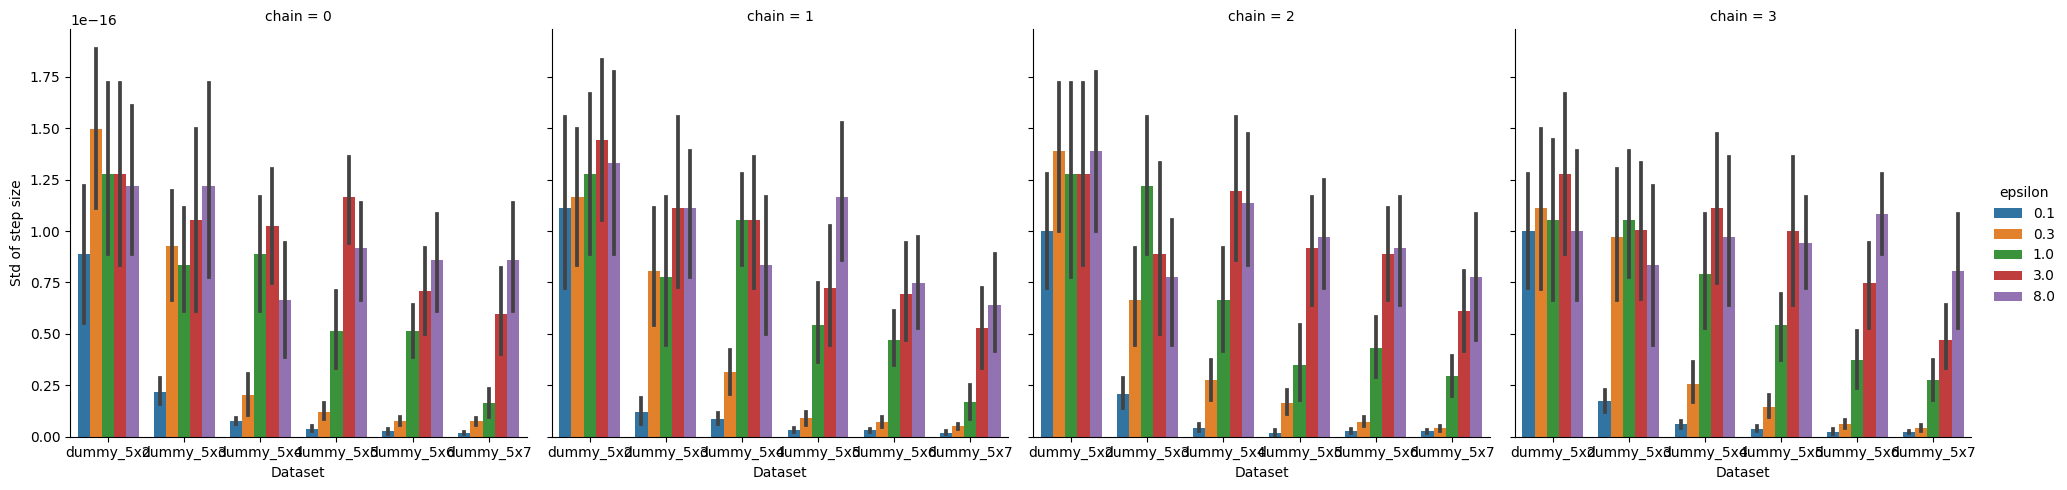

In [219]:
plt.figure(figsize=(30, 16))
f = sns.catplot(data=step_df, kind="bar", x="dataset", y="step_mean", hue="epsilon", col="chain")
plt.figure(figsize=(30, 16))
g = sns.catplot(data=step_df, kind="bar", x="dataset", y="step_std", hue="epsilon", col="chain")

f.set_xlabels("Dataset")
f.set_ylabels("Mean of step size")

g.set_xlabels("Dataset")
g.set_ylabels("Std of step size")